In [30]:
import os,sys, importlib, numpy as np
import matplotlib.pyplot as plt
import jpcm
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [39]:
# user=os.popen('whoami').read().replace('\n','')
user='mitt-wsl'
print(f'User: {user}')
modelname = "BERT"
model = f"{modelname}/control/WV_0_PC_0_EH_0_PS_1_6"

spec = importlib.util.spec_from_file_location("module.name", f'./user/{user}_param.py')
userparam = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = userparam
spec.loader.exec_module(userparam)

checkpoint_dir = userparam.param['model_dir']

result_path = f"{checkpoint_dir}/{model}/test_result/"

User: mitt-wsl


In [40]:
gt = np.load(f'{result_path}true_data.npy'.replace('/mnt/c','C:'))
pd = np.load(f'{result_path}pred_data.npy'.replace('/mnt/c','C:'))

In [41]:
print(gt.shape)
print(pd.shape)

(3, 17, 40, 1, 64, 64)
(3, 17, 40, 1, 64, 64)


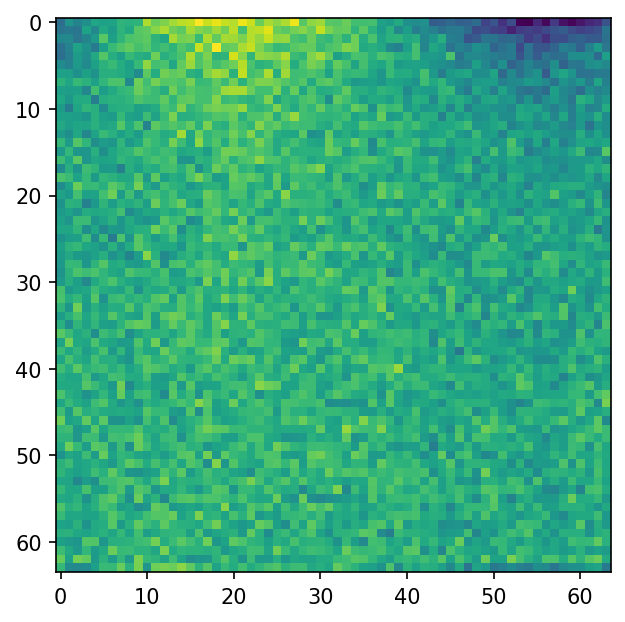

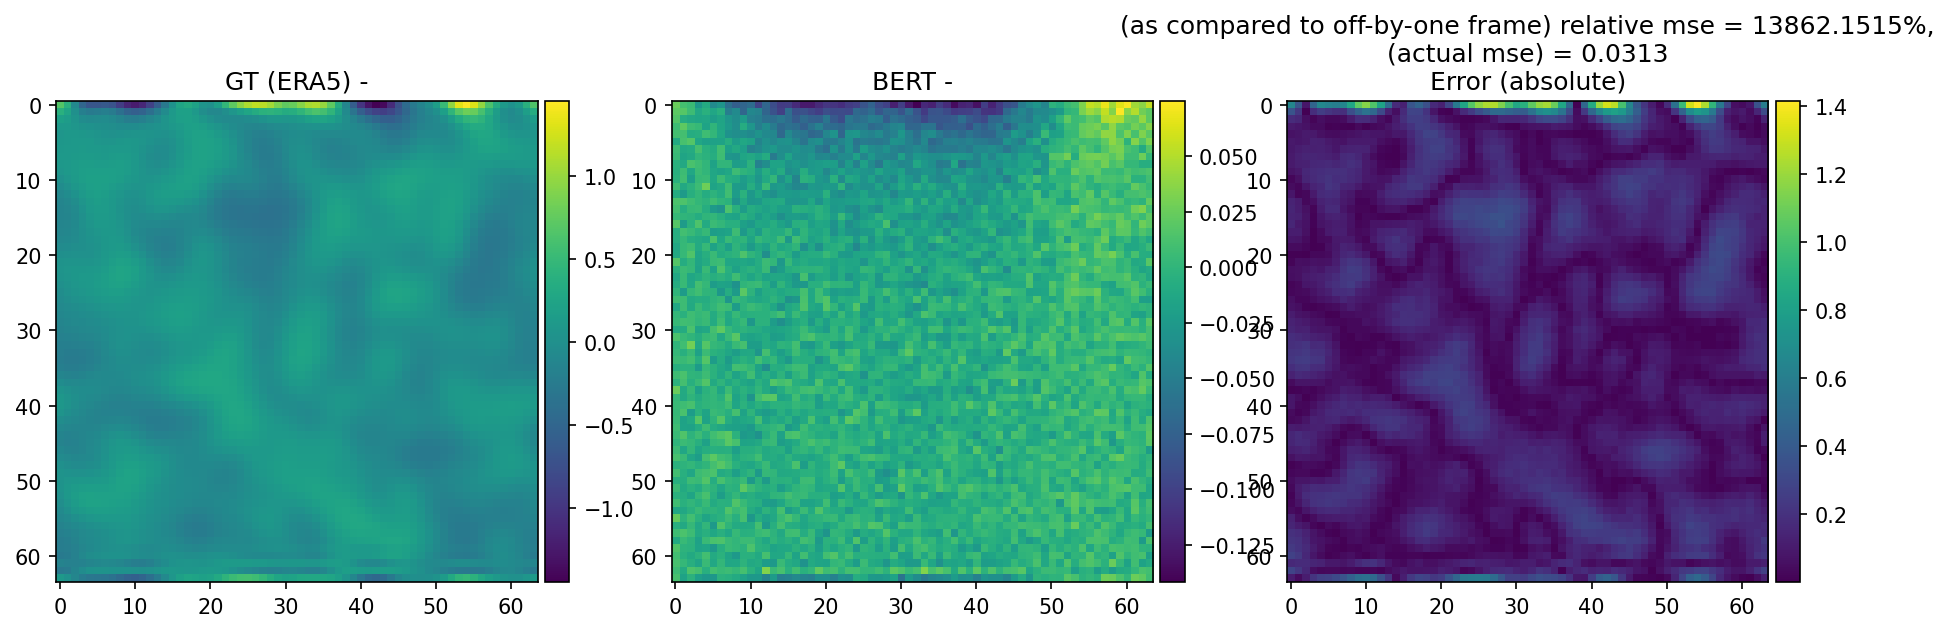

In [42]:
# stepi = 5
# var_dicts = {0:'u wind', 1:'v wind', 2:'Sea Surface Temperature',
#             3:'Surface Pressure', 4:'Precipitation'}
var_dicts = {0:'-',}
shift = gt.shape[2] - pd.shape[2]
var = 0
b =  0 # BATCH
a = 0 # MINIBATCH
stepi = 22

fig, axs = plt.subplots(1,3, figsize=(15,10))
ax0 = axs[0]
im0 = ax0.imshow(gt[b,a,shift+stepi,var,:,:])
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')
ax0.set_title('GT (ERA5) '+var_dicts[var])

ax1 = axs[1]
im1 = ax1.imshow(pd[b,a,stepi,var,:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title(f'{modelname} '+var_dicts[var])

ax2 = axs[2]
d = gt[b,a,shift+stepi,var,:,:]-pd[b,a,stepi,var,:,:]
d0 = gt[b,a,shift+stepi+1,var,:,:]-gt[b,a,shift+stepi,var,:,:]
im2 = ax2.imshow(np.abs(d))
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')
mse = np.mean(d**2)
meanMse = mse*100 / np.mean(d0**2)
# medianMse = np.median(d**2)*100 / np.median(d0**2)
ax2.set_title(f'(as compared to off-by-one frame) relative mse = {meanMse:.4f}%,\n(actual mse) = {mse:.4f}\nError (absolute)')
plt.show()

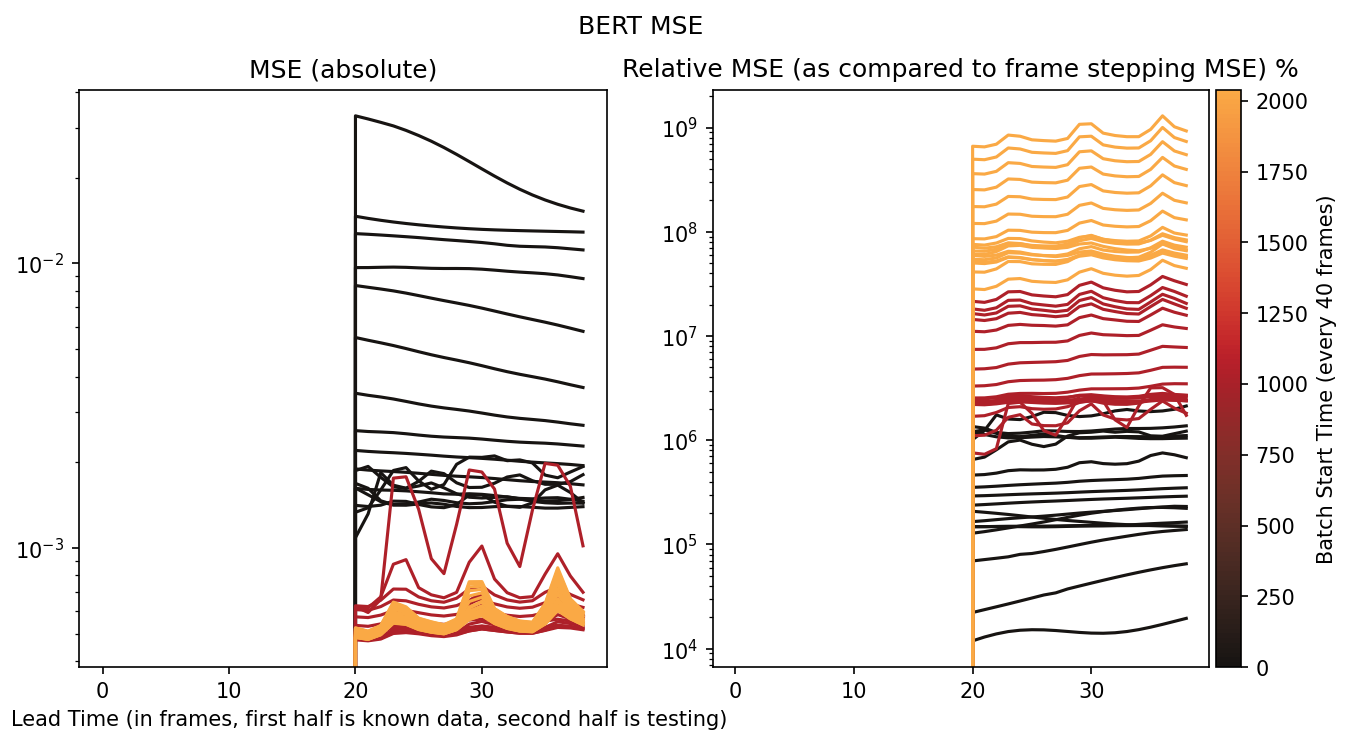

In [43]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
cmap = jpcm.get('desert')
cs = cmap.resampled(gt.shape[0]).colors
for ba in range(gt.shape[0]*gt.shape[1]): # for each batch (i.e. each general section of time)
    b = ba // gt.shape[1]
    a = ba % gt.shape[1]
    means = []
    relMeans = []
    for f in range(gt.shape[2]-shift-1): # for each frame (i.e. each time step in the batch)
        d = gt[b,a,shift+f,var,:,:]-pd[b,a,f,var,:,:]
        d0 = gt[b,a,shift+f+1,var,:,:]-gt[b,a,shift+f,var,:,:]
        meanMse = np.mean(d**2)
        meanShiftMse = np.mean(d0**2)
        means.append(meanMse) # average over minibatch
        relMeans.append(100*meanMse/meanShiftMse) # average over minibatch

    axs[0].plot(means, color=cs[b], label=f'Batch {b}')
    axs[1].plot(relMeans, color=cs[b], label=f'Batch {b}')
# plt.plot(medians, label='Median')
axs[0].set_xlabel('        Lead Time (in frames, first half is known data, second half is testing)')
axs[0].set_title('MSE (absolute)')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Relative MSE (as compared to frame stepping MSE) %')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(0, gt.shape[0] * gt.shape[1] * gt.shape[2]), cmap=cmap
    ),
    cax=cax,
    orientation='vertical',
    label=f'Batch Start Time (every {gt.shape[2]} frames)',
    # ticks=np.arange(0, gt.shape[0] * gt.shape[1] * gt.shape[2], gt.shape[2]).tolist(),
)
# plt.legend()
plt.suptitle(f'{modelname} MSE')
plt.savefig(f'{result_path}mse.png'.replace('/mnt/c','C:'))
plt.show()

In [45]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()
imd = pd.reshape(-1, *pd.shape[4:])


def animate(i):
    plt.clf()
    plt.imshow(imd[i])
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit']=1000000000
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=imd.shape[0], interval=100, )
ani

In [ ]:
ani.save(f'{result_path}animation.mp4'.replace('/mnt/c','C:'), writer='ffmpeg', fps=10)

KeyboardInterrupt: 

skip the following:

In [ ]:
ss = np.std(pd[b,a,20:,var,:,:]-pd[b,a,19:-1,var,:,:] ,axis=(1,2)) **2   

In [ ]:
ss

In [ ]:
d = np.log(ss/ss[0])/np.log(2)
plt.plot(np.arange(1,20),d[1:])
plt.show()
plt.plot(np.arange(1,20),d[1:]-d[:-1])
plt.show()
d[1:]-d[:-1]

In [ ]:
ss = np.std(gt[b,a,:,var,:,:] ,axis=(1,2)) 

In [ ]:
np.log(ss[-1]/ss[0])